# MNIST Partial Questing - with Curves!

Attempting the partial quest with curves in our architecture.

**Addendum:**

When we impose intermediate features on our network, it seems that some of the layers die - a lot of the weights appear to go to 0.

Let's take a look at how our weights evolve during training.

## Imports

In [1]:
import random

import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

from helpers import load_images, load_labels, visualize_image, get_edges, generate_intermediate_edge_labels, horizontal_kernel, vertical_kernel, \
    load_intermediate_labels, generate_intermediate_curve_labels, save_intermediate_labels

## Globals

In [2]:
MODEL_NAME = "./curve_partial.pth"

## Set Device to GPU

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We will be using device: {device}")

We will be using device: cuda


## Load Data

In [4]:
# train data
train_images = load_images("./data/train-images-idx3-ubyte/train-images-idx3-ubyte")
train_labels = load_labels("./data/train-labels-idx1-ubyte/train-labels-idx1-ubyte")

train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels,
    test_size=1/6,  # 10k validation
    stratify=train_labels,
    random_state=42  # for reproducibility
)

# test data
test_images = load_images("./data/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte")
test_labels = load_labels("./data/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte")

In [5]:
print("Train images shape:", train_images.shape)
print("Val images shape:", val_images.shape)
print("Test images shape:", test_images.shape)

Train images shape: (50000, 28, 28)
Val images shape: (10000, 28, 28)
Test images shape: (10000, 28, 28)


## Visualize an Image

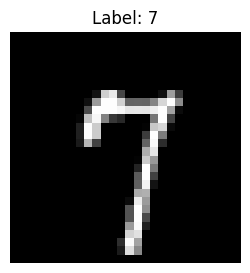

In [6]:
sample_image = train_images[0]
sample_label = train_labels[0]
visualize_image(sample_image, sample_label)

## Convolutions to get Horizontal Edges

### Example Image

In [7]:
horizontal_edges = get_edges(horizontal_kernel, sample_image)

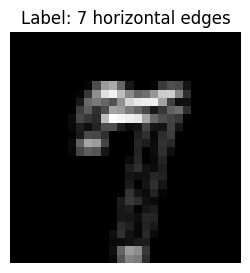

In [8]:
visualize_image(horizontal_edges, f"{sample_label} horizontal edges")

### Extending the Dataset

In [9]:
train_horizontal_image_labels = load_intermediate_labels("train_horizontal_image_labels.pkl")

In [10]:
val_horizontal_image_labels = load_intermediate_labels("val_horizontal_image_labels.pkl")

In [11]:
test_horizontal_image_labels = load_intermediate_labels("test_horizontal_image_labels.pkl")

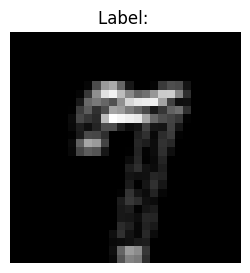

In [12]:
visualize_image(train_horizontal_image_labels[0].reshape(28, 28), "")

## Convolutions to get Vertical Edges

### Example Image

In [13]:
vertical_edges = get_edges(vertical_kernel, sample_image)

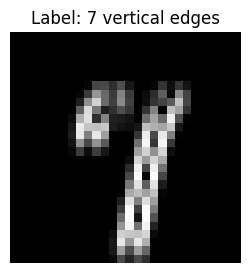

In [14]:
visualize_image(vertical_edges, f"{sample_label} vertical edges")

### Extending the Dataset

In [15]:
train_vertical_image_labels = load_intermediate_labels("train_vertical_image_labels.pkl")

In [16]:
val_vertical_image_labels = load_intermediate_labels("val_vertical_image_labels.pkl")

In [17]:
test_vertical_image_labels = load_intermediate_labels("test_vertical_image_labels.pkl")

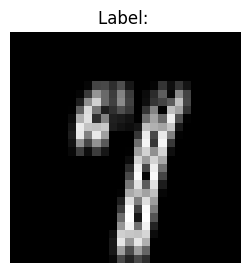

In [18]:
visualize_image(train_vertical_image_labels[0].reshape(28, 28), "")

## Convolutions to get Curves

Some extra steps here to generate better curves... this might be a point to re-visit in testing, but it largely comes from needing to rotate our curve kernel to capture curves.

The point to revisit is perhaps we want each unique rotation to be represented by an intermediate layer. Similar to how edges have been split into vertical and horizontal layers, perhaps we want layers to be dedicated to only one curve, instead of the culmination of curves.

### Example Image

In [19]:
curves = generate_intermediate_curve_labels([sample_image])

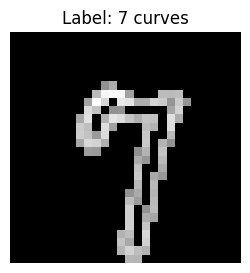

In [20]:
visualize_image(curves[0].reshape(28, 28), f"{sample_label} curves")

### Extending the dataset

In [21]:
train_curve_labels = load_intermediate_labels("train_curve_labels.pkl")

In [22]:
val_curve_labels = load_intermediate_labels("val_curve_labels.pkl")

In [23]:
test_curve_labels = load_intermediate_labels("test_curve_labels.pkl")

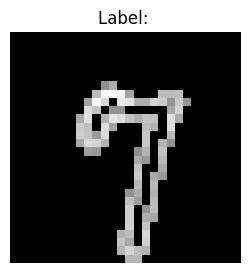

In [24]:
visualize_image(train_curve_labels[0].reshape(28, 28), "")

# Base Test

## Architecture

Updating the architecture to take into account our new curve layer.

In [25]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        layer_size_by_pixels = 28*28
        
        self.flatten = nn.Flatten()
        
        # define layers separately to have access to each
        self.horizontal_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.vertical_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.curve_layer = nn.Linear(layer_size_by_pixels, layer_size_by_pixels)
        self.classification_layer = nn.Linear(layer_size_by_pixels, 10)
        self.activation_function = nn.ReLU()

    def forward(self, x):
        x = self.flatten(x)

        # horizontal processing
        horizontal_out = self.horizontal_layer(x)
        horizontal_act = self.activation_function(horizontal_out)

        # vertical processing
        vertical_out = self.vertical_layer(horizontal_act)
        vertical_act = self.activation_function(vertical_out)

        # curve processing
        curve_out = self.curve_layer(vertical_act)
        curve_act = self.activation_function(curve_out)

        # classification
        classification_out = self.classification_layer(curve_act)
        
        return classification_out, curve_act, vertical_act, horizontal_act

In [26]:
# for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [27]:
model = NeuralNetwork().to(device)

# loss functions
classification_loss_fn = nn.CrossEntropyLoss()
horizontal_loss_fn = nn.MSELoss()
vertical_loss_fn = nn.MSELoss()
curve_loss_fn = nn.MSELoss()

# optimizers
optimizer = torch.optim.Adam(model.parameters())

In [28]:
print(f"Model weights (to compare below): {model.horizontal_layer.weight[0][:5].detach().cpu().numpy()}")

Model weights (to compare below): [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]


### Verify Reproducibility

In [29]:
# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
model_compare_one = NeuralNetwork().to(device)
first_set_of_weights = model_compare_one.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("First set of weights:", first_set_of_weights)

# reset the seed
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

model_compare_two = NeuralNetwork().to(device)
second_set_of_weights = model_compare_two.horizontal_layer.weight[0][:5].detach().cpu().numpy()
print("Second set of weights:", second_set_of_weights)

print(f"Are the two sets equal: {first_set_of_weights == second_set_of_weights}")

First set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Second set of weights: [ 0.02730495  0.02964314 -0.00836687  0.03280755 -0.00782513]
Are the two sets equal: [ True  True  True  True  True]


## Dataloader

In [30]:
class EdgeDataset(Dataset):
    def __init__(self, images, labels, horizontal_edges, vertical_edges, curves):
        self.images = images
        self.labels = labels
        self.horizontal_edges = horizontal_edges
        self.vertical_edges = vertical_edges
        self.curves = curves

    def __len__(self):
        assert len(self.images) == len(self.labels)
        return len(self.images)

    def __getitem__(self, idx):
        return (
            torch.from_numpy(self.images[idx].copy()).float(),
            torch.tensor(self.labels[idx].copy(), dtype=torch.long),
            torch.from_numpy(self.horizontal_edges[idx].copy()).float(),
            torch.from_numpy(self.vertical_edges[idx].copy()).float(),
            torch.from_numpy(self.curves[idx].copy()).float(),
        )

In [31]:
# for reproducibility on training
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator().manual_seed(seed)

In [32]:
# training data
train_dataset = EdgeDataset(train_images, train_labels, train_horizontal_image_labels, train_vertical_image_labels, train_curve_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, worker_init_fn=seed_worker, generator=generator)

# validation data
val_dataset = EdgeDataset(val_images, val_labels, val_horizontal_image_labels, val_vertical_image_labels, val_curve_labels)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, num_workers=4)  # larger batch size for faster validation

# test data
test_dataset = EdgeDataset(test_images, test_labels, test_horizontal_image_labels, test_vertical_image_labels, test_curve_labels)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

## Training Loop

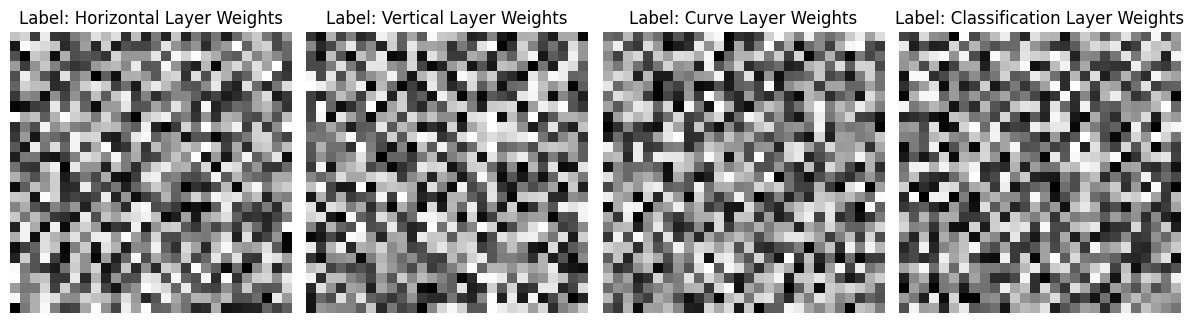

Epoch 1/20
  Train Loss: 3580.4712
  Val Loss: 1.1020 | Val Acc: 85.12%


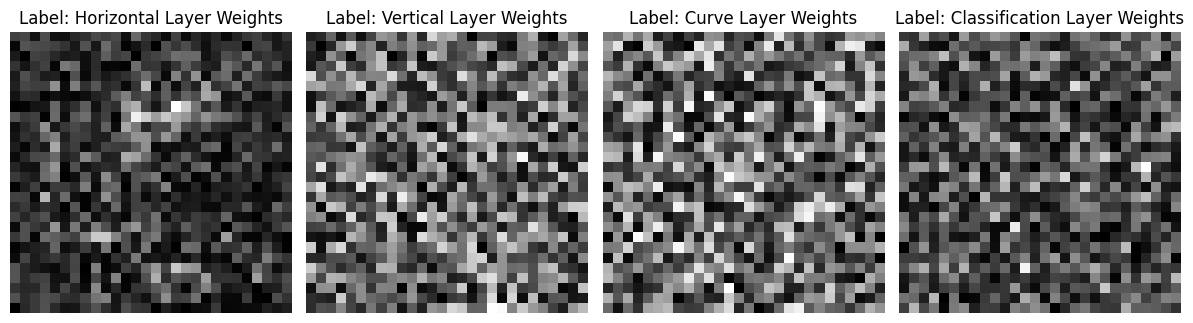

Epoch 2/20
  Train Loss: 2754.4204
  Val Loss: 1.6358 | Val Acc: 83.15%


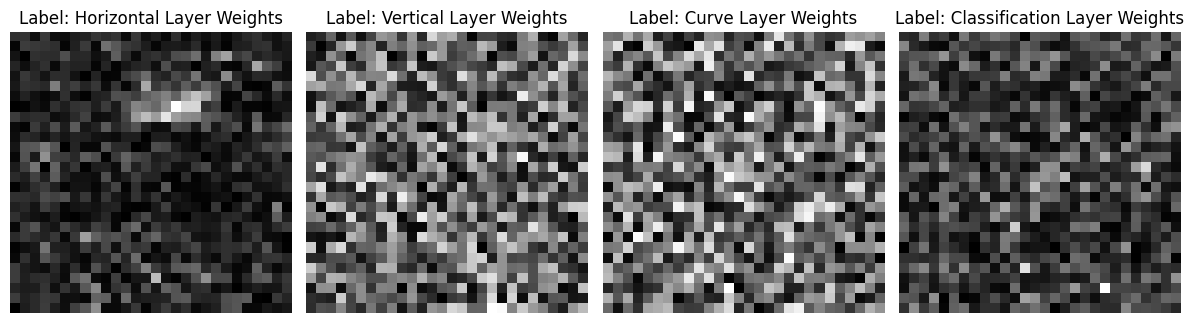

Epoch 3/20
  Train Loss: 2531.2976
  Val Loss: 1.3231 | Val Acc: 87.41%


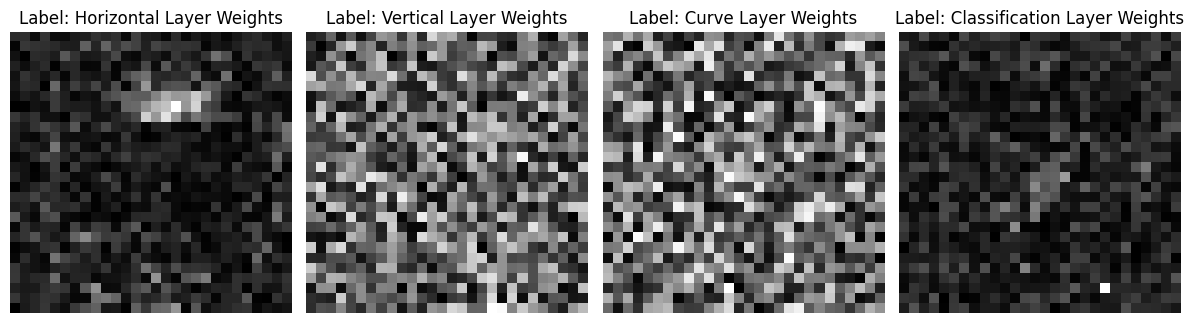

Epoch 4/20
  Train Loss: 2413.7090
  Val Loss: 1.2175 | Val Acc: 88.36%


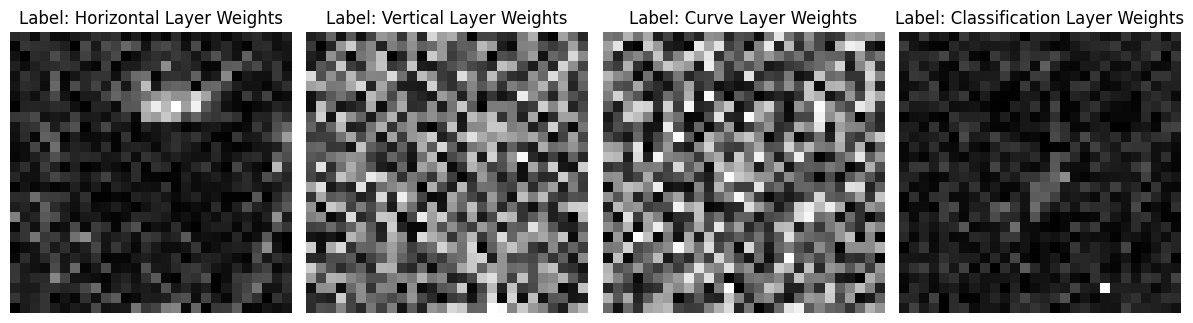

Epoch 5/20
  Train Loss: 2344.2314
  Val Loss: 1.7357 | Val Acc: 84.38%


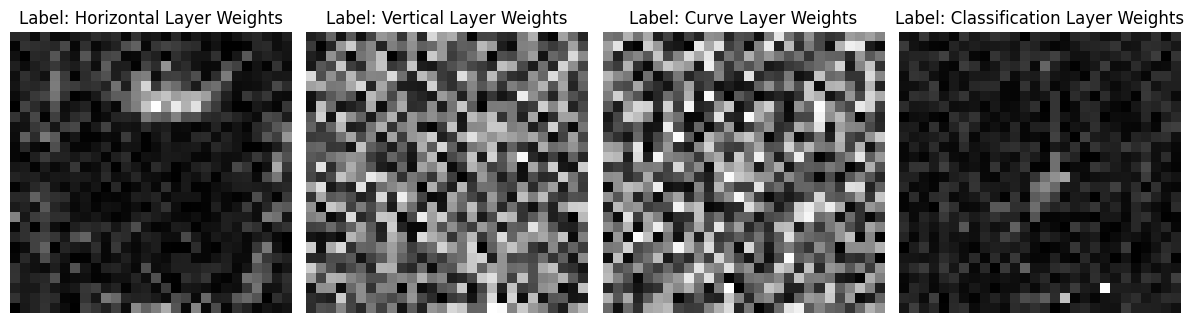

Epoch 6/20
  Train Loss: 2291.4606
  Val Loss: 1.5160 | Val Acc: 86.52%


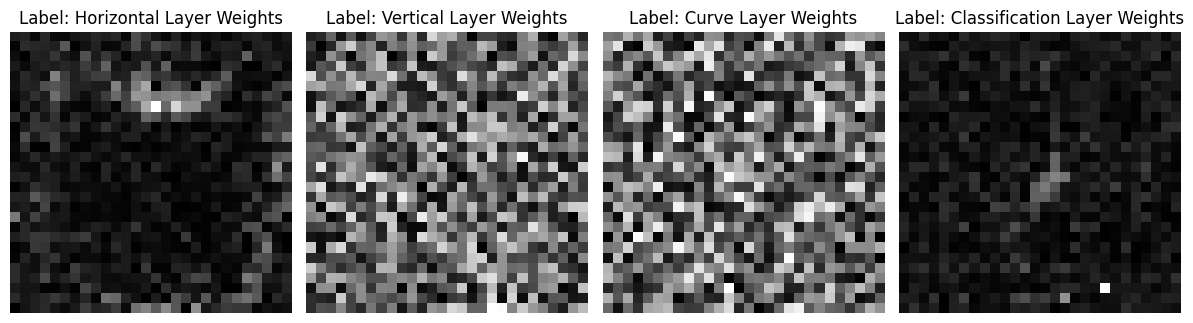

Epoch 7/20
  Train Loss: 2254.3216
  Val Loss: 1.5053 | Val Acc: 86.97%


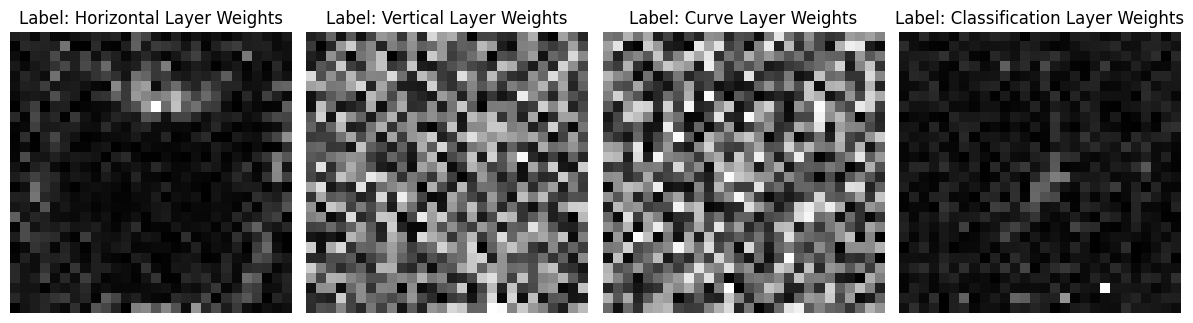

Epoch 8/20
  Train Loss: 2226.4778
  Val Loss: 1.5227 | Val Acc: 86.87%


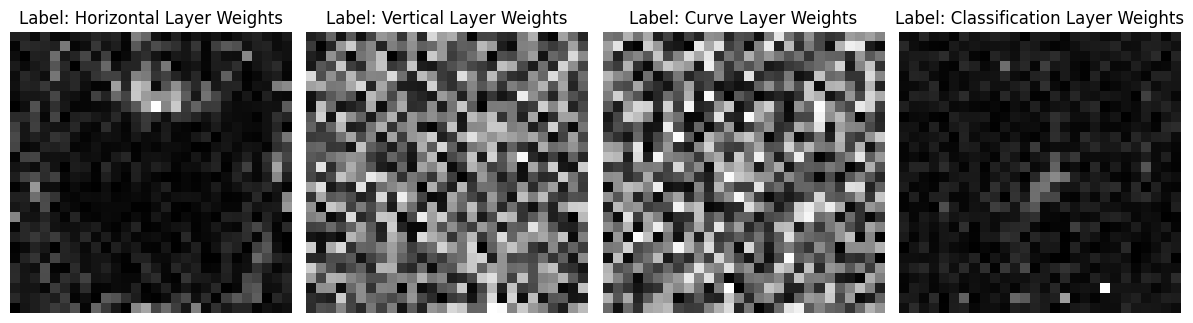

Epoch 9/20
  Train Loss: 2206.2911
  Val Loss: 1.4808 | Val Acc: 87.91%


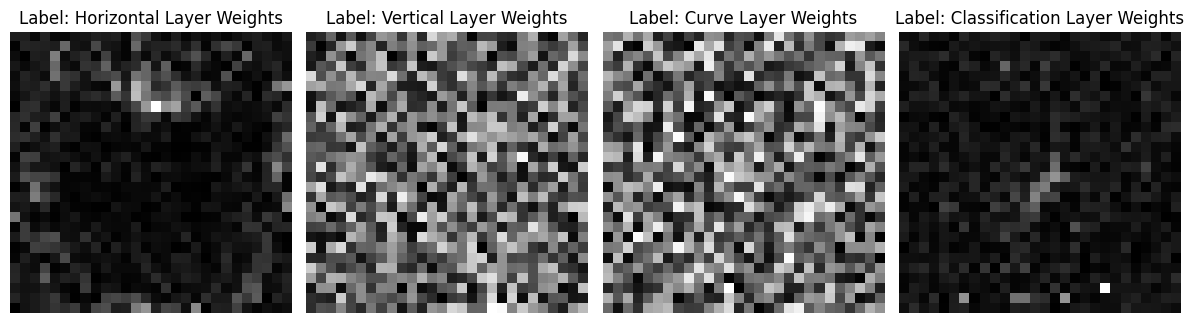

Epoch 10/20
  Train Loss: 2187.8195
  Val Loss: 1.3387 | Val Acc: 88.97%


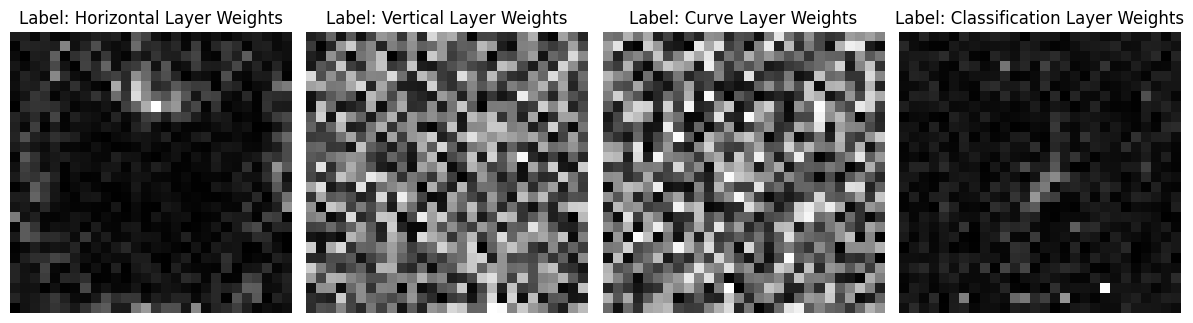

Epoch 11/20
  Train Loss: 2175.7087
  Val Loss: 1.3883 | Val Acc: 88.69%


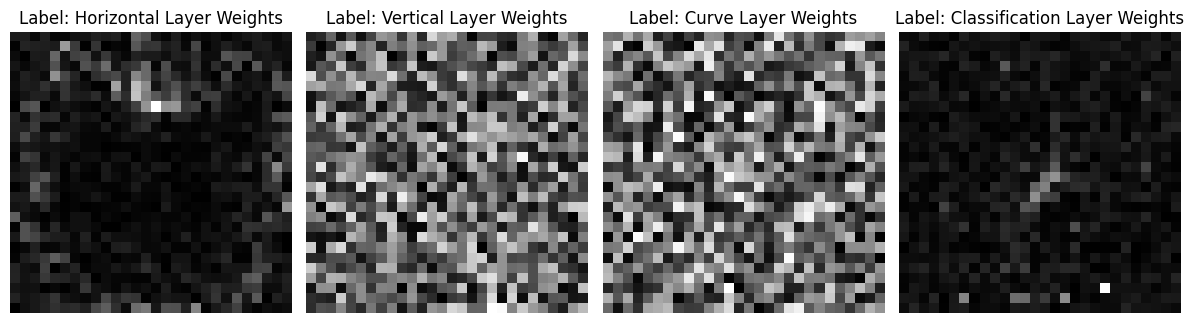

Epoch 12/20
  Train Loss: 2164.5826
  Val Loss: 1.6075 | Val Acc: 86.92%


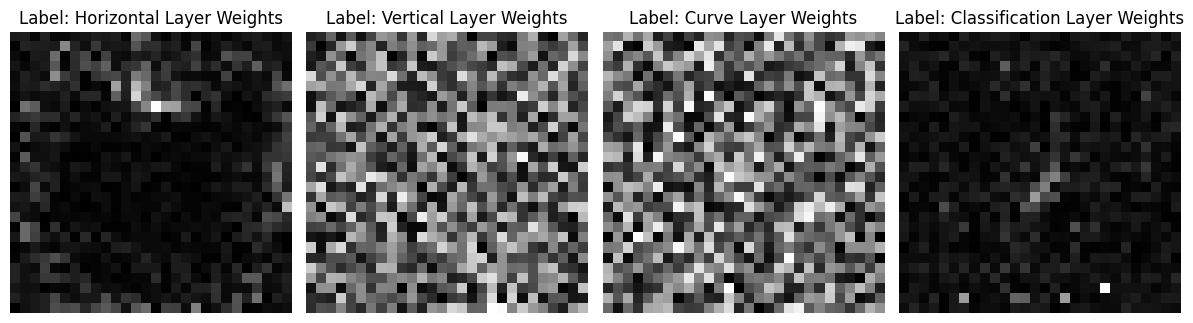

Epoch 13/20
  Train Loss: 2156.0861
  Val Loss: 1.7124 | Val Acc: 86.45%


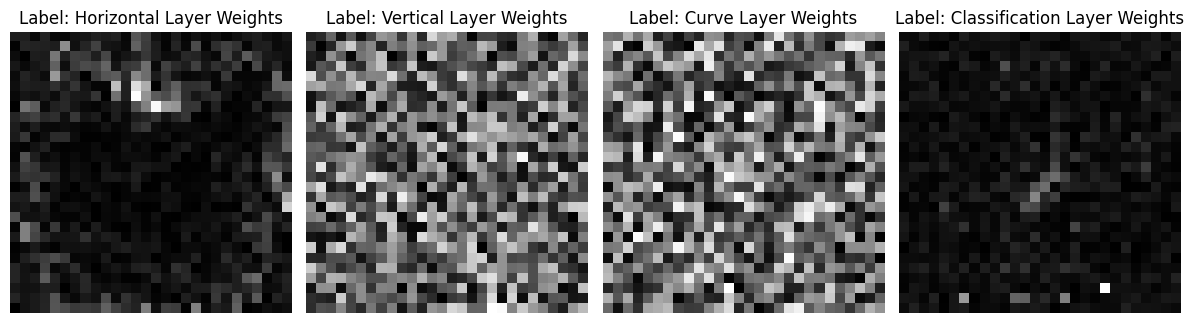

Epoch 14/20
  Train Loss: 2146.5401
  Val Loss: 1.6818 | Val Acc: 87.29%


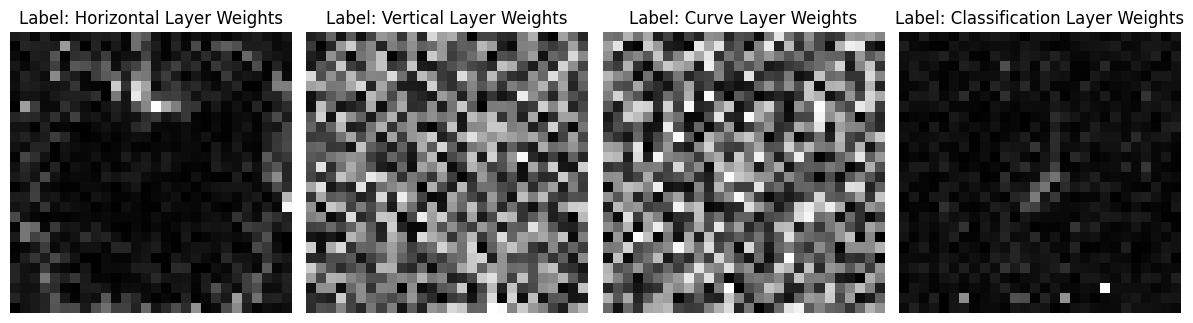

Epoch 15/20
  Train Loss: 2138.2241
  Val Loss: 1.6861 | Val Acc: 86.59%


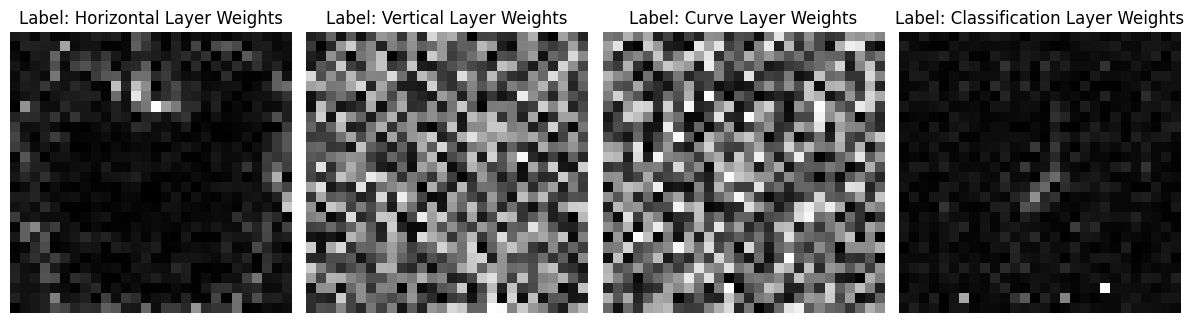

Epoch 16/20
  Train Loss: 2132.8028
  Val Loss: 1.5105 | Val Acc: 88.66%


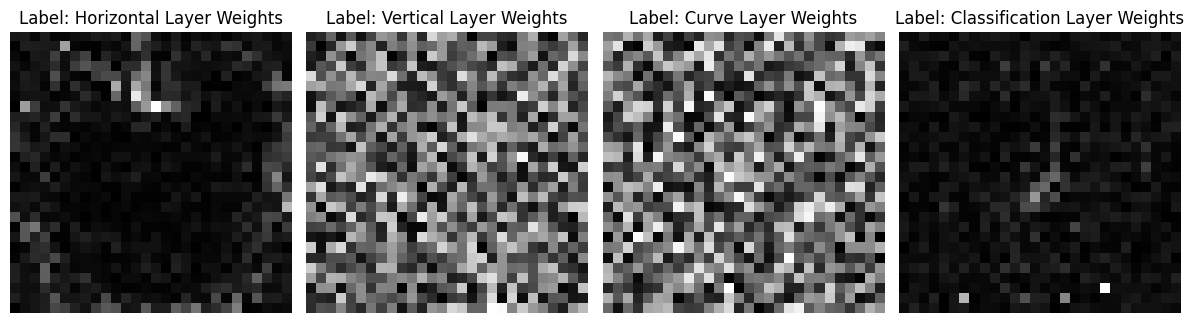

Epoch 17/20
  Train Loss: 2126.3055
  Val Loss: 1.3907 | Val Acc: 89.17%


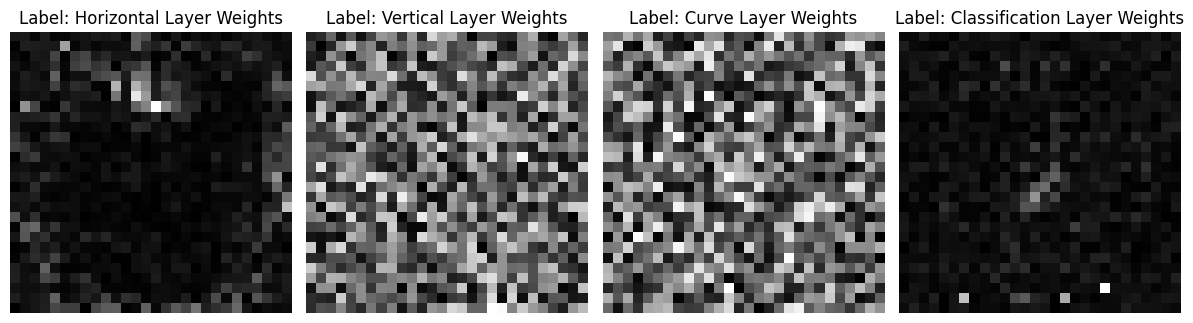

Epoch 18/20
  Train Loss: 2121.1601
  Val Loss: 1.4746 | Val Acc: 88.33%


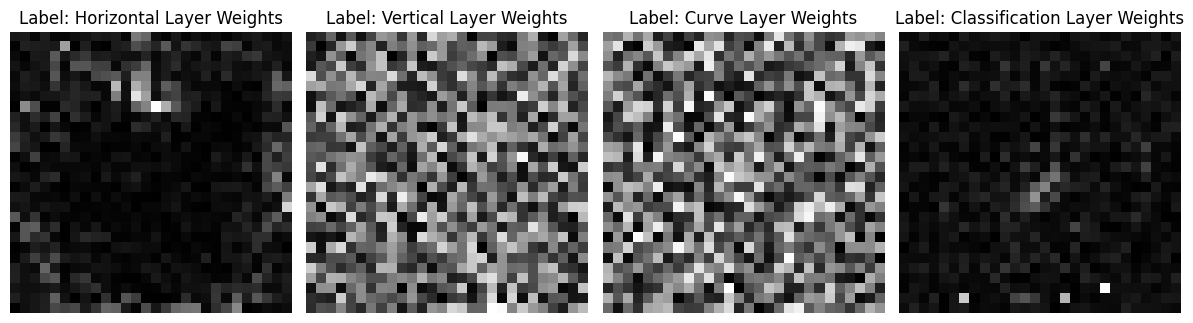

Epoch 19/20
  Train Loss: 2115.2517
  Val Loss: 1.8051 | Val Acc: 86.76%


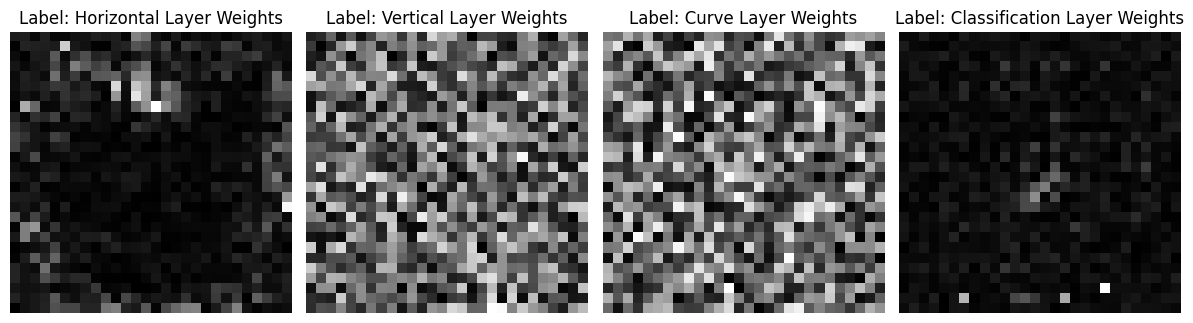

Epoch 20/20
  Train Loss: 2112.4563
  Val Loss: 1.7237 | Val Acc: 86.83%


In [33]:
num_epochs = 20
best_val_loss = float('inf')
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # set the model to training mode - this is currently a no-op
    train_loss = 0.0

    # visualize weights at each layer during training
    classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    curve_w = np.abs(model.curve_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
    horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

    fig, axes = plt.subplots(1, 4, figsize=(12, 5))

    visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
    visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
    visualize_image(curve_w, "Curve Layer Weights", ax=axes[2])
    visualize_image(classification_w, "Classification Layer Weights", ax=axes[3])
    
    plt.tight_layout()
    plt.show()

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=False)
    for batch in train_bar:
        # deconstruct batch items
        images, labels, horizontal_labels, vertical_labels, curve_labels = batch
        images, labels, horizontal_labels, vertical_labels, curve_labels = images.to(device), \
            labels.to(device), \
            horizontal_labels.to(device), \
            vertical_labels.to(device), \
            curve_labels.to(device)
        
        # forward pass
        classification_out, curve_act, vertical_act, horizontal_act = model(images)
        
        # --- Loss and Backprop ---

        # clear gradients
        optimizer.zero_grad()

        # curve_loss 
        curve_loss = curve_loss_fn(curve_act, curve_labels)
        
        # vertical loss
        vertical_loss = vertical_loss_fn(vertical_act, vertical_labels)

        # horizontal loss
        horizontal_loss = horizontal_loss_fn(horizontal_act, horizontal_labels)

        # classification loss
        classification_loss = classification_loss_fn(classification_out, labels)

        # total loss
        total_loss = curve_loss + vertical_loss + horizontal_loss + classification_loss
        total_loss.backward()
        
        optimizer.step()

        # update progress
        train_loss += total_loss.item()
        train_bar.set_postfix(loss=classification_loss.item())

    # --- Validation Phase ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{num_epochs} [Val]", leave=False)
    with torch.no_grad():
        for batch in val_bar:
            # deconstruct
            images, labels, _, _, _ = batch
            images, labels = images.to(device), labels.to(device)

            # forward pass
            classification_out, _, _, _ = model(images)

            # compute loss
            loss = classification_loss_fn(classification_out, labels)

            # calculate metrics
            val_loss += loss.item()
            _, predicted = torch.max(classification_out, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # epoch stats
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.2f}%")

    # save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), MODEL_NAME)

## Eval

In [34]:
model.load_state_dict(torch.load(MODEL_NAME))
model.eval()  # again currently a no-op

test_correct = 0
test_total = 0

with torch.no_grad():
    test_bar = tqdm(test_loader, desc=f"Evaluation")
    for batch in test_bar:
        images, labels, _, _, _ = batch
        images, labels = images.to(device), labels.to(device)

        # forward pass
        classification_out, _, _, _ = model(images)

        # stats
        _, predicted = torch.max(classification_out, 1)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_accuracy = 100 * test_correct / test_total
print(f"Final Test Accuracy: {test_accuracy:.2f}%")

Evaluation: 100%|██████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 304.86it/s]

Final Test Accuracy: 85.61%


# Exploring Model Results

## Visualizing Weights

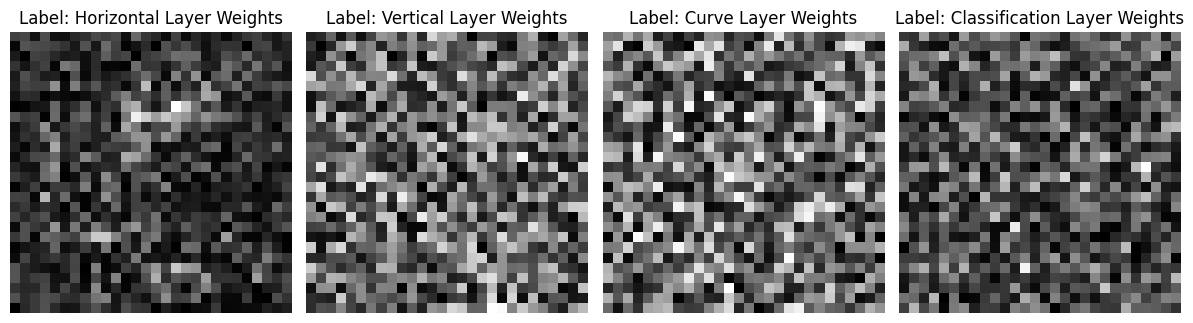

In [35]:
classification_w = np.abs(model.classification_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
curve_w = np.abs(model.curve_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
vertical_w = np.abs(model.vertical_layer.weight[0].reshape(28, 28).detach().cpu().numpy())
horizontal_w = np.abs(model.horizontal_layer.weight[0].reshape(28, 28).detach().cpu().numpy())

fig, axes = plt.subplots(1, 4, figsize=(12, 5))

visualize_image(horizontal_w, "Horizontal Layer Weights", ax=axes[0])
visualize_image(vertical_w, "Vertical Layer Weights", ax=axes[1])
visualize_image(curve_w, "Curve Layer Weights", ax=axes[2])
visualize_image(classification_w, "Classification Layer Weights", ax=axes[3])

plt.tight_layout()
plt.show()